# Lab 5: LHC Particle Physics Data Analysis

**Author:** Nirmal Kumar Marimuthu

**Course:** Physics 434 - Data Analysis Lab  
**Objective:** Explore LHC particle physics data and optimize discovery significance through event selection

In this lab, you will work with realistic particle physics data from the Large Hadron Collider (LHC). The goal is to identify Higgs boson signals from QCD background noise using jet substructure analysis and cut-based optimization.

## Dataset Information

Two pT (transverse momentum) ranges are provided:

### Low pT (250-500 GeV/c): `Sample_pt_250_500`
- **Training samples:**
  - `higgs_100000_pt_250_500.pkl` (Expected yields: N_higgs = 100)
  - `qcd_100000_pt_250_500.pkl` (Expected yields: N_qcd = 20,000)
- **Pseudo-experiments:**
  - `data_highLumi_pt_250_500.h5`
  - `data_lowLumi_pt_250_500.h5`

### High pT (1000-1200 GeV/c): `Sample_pt_1000_1200`
- **Training samples:**
  - `higgs_100000_pt_1000_1200.pkl` (Expected yields: N_higgs = 50)
  - `qcd_100000_pt_1000_1200.pkl` (Expected yields: N_qcd = 2,000)
- **Pseudo-experiments:**
  - `data_highLumi_pt_1000_1200.h5`
  - `data_lowLumi_pt_1000_1200.h5`

## Physics Background

### What is a Jet?
A jet is a collection of particles traveling in the same direction, originating from a hard quark or gluon through bremsstrahlung and fragmentation processes.

### Jet Substructure
At high transverse momenta, heavy particles (W, Z, Higgs, top quarks) have collimated decays. Standard jet identification fails because all decay products end up in a single jet. **Jet substructure variables** computed from constituent 4-momenta help distinguish boosted heavy particles with two-pronged decays from QCD jets.

### Key Variables:
- **mass**: Jet invariant mass (GeV)
- **d2**: Jet substructure variable for two-pronged discrimination
- **η (eta)**: Pseudorapidity (geometric quantity related to polar angle)
- **φ (phi)**: Azimuthal angle around the beam

**Extended Reading:** 
- ATLAS detector: https://arxiv.org/pdf/1709.04533.pdf
- Jet substructure: https://arxiv.org/abs/1201.0008

## Setup and Data Loading

In [99]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [100]:
#Load the QCD background data
with open('LHC/Sample_pt_250_500/qcd_100000_pt_250_500.pkl', 'rb') as f:
    qcd_data = pickle.load(f)


In [101]:
# Load the Higgs signal data
with open('LHC/Sample_pt_250_500/higgs_100000_pt_250_500.pkl', 'rb') as f:
    higgs_data = pickle.load(f)


In [102]:
# Explore the data structure
# Print the keys available in the data dictionary
print("QCD Data Keys:", qcd_data.keys())
print("Higgs Data Keys:", higgs_data.keys())
# Print the first few values of 'mass' and 'd2'
print("QCD Mass:", qcd_data['mass'][:5])
print("QCD d2:", qcd_data['d2'][:5])
print("Higgs Mass:", higgs_data['mass'][:5])
print("Higgs d2:", higgs_data['d2'][:5])

QCD Data Keys: Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')
Higgs Data Keys: Index(['pt', 'eta', 'phi', 'mass', 'ee2', 'ee3', 'd2', 'angularity', 't1',
       't2', 't3', 't21', 't32', 'KtDeltaR'],
      dtype='object')
QCD Mass: 0    125.298720
1     88.047054
2     85.794174
3     42.947328
4     59.542227
Name: mass, dtype: float64
QCD d2: 0    3.304886
1    2.439089
2    4.118371
3    8.038338
4    6.353842
Name: d2, dtype: float64
Higgs Mass: 0    125.150365
1    130.552672
2    125.703063
3    126.215853
4    132.182504
Name: mass, dtype: float64
Higgs d2: 0    1.298020
1    1.445626
2    0.986597
3    1.218467
4    1.291784
Name: d2, dtype: float64


# Task 1: Visualization (3 points)

Explore the low pT dataset (`Sample_pt_250_500`). Make representative plots of each feature to understand the data structure and characteristics.

## Part (a): Individual Feature Distributions

Create histograms for each available feature in both signal and background datasets.

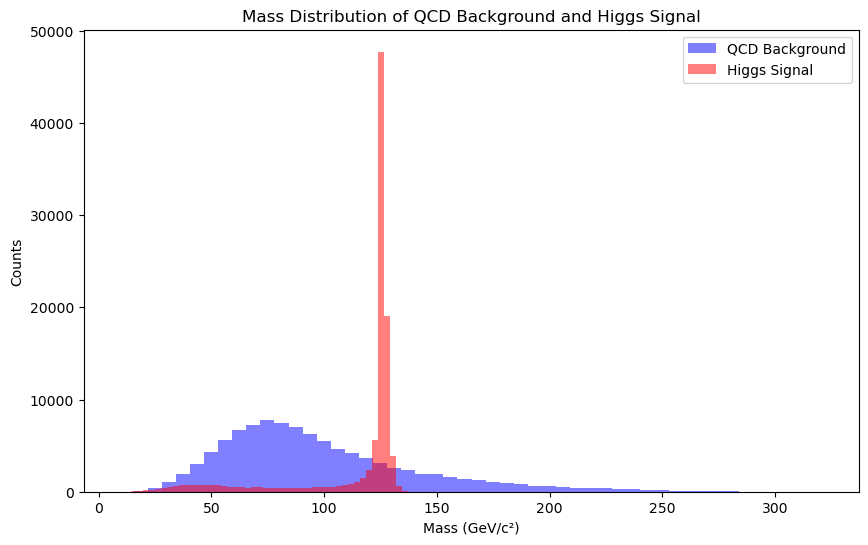

In [103]:
# Plot mass distributions for signal and background
plt.figure(figsize=(10,6))
plt.hist(qcd_data['mass'], bins=50, alpha=0.5, label='QCD Background', color='blue')
# Create overlaid histograms with proper labels and legends
plt.hist(higgs_data['mass'], bins=50, alpha=0.5, label='Higgs Signal', color='red')
plt.xlabel('Mass (GeV/c²)')
plt.ylabel('Counts')
plt.title('Mass Distribution of QCD Background and Higgs Signal')
plt.legend()
plt.show()

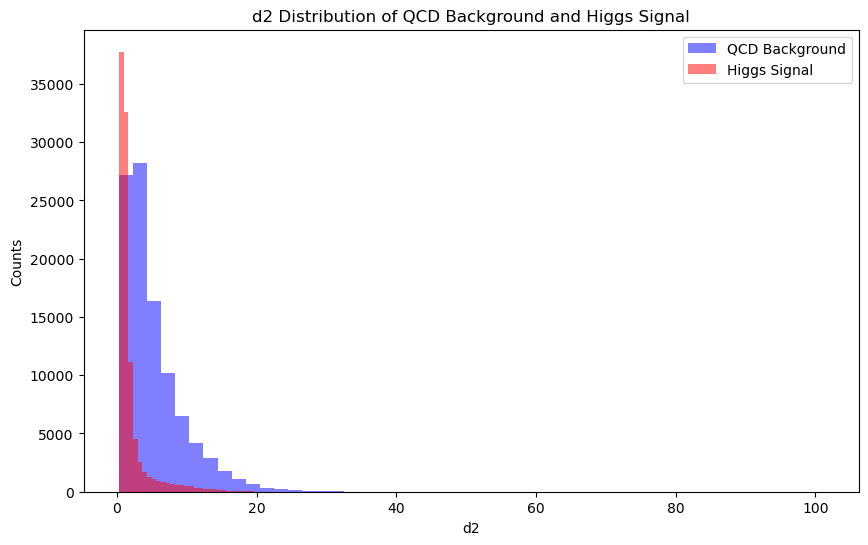

In [104]:
# Plot d2 distributions for signal and background
plt.figure(figsize=(10,6))
plt.hist(qcd_data['d2'], bins=50, alpha=0.5, label='QCD Background', color='blue')
# Create overlaid histograms with proper labels and legends
plt.hist(higgs_data['d2'], bins=50, alpha=0.5, label='Higgs Signal', color='red')
plt.xlabel('d2')
plt.ylabel('Counts')
plt.title('d2 Distribution of QCD Background and Higgs Signal')
plt.legend()
plt.show()

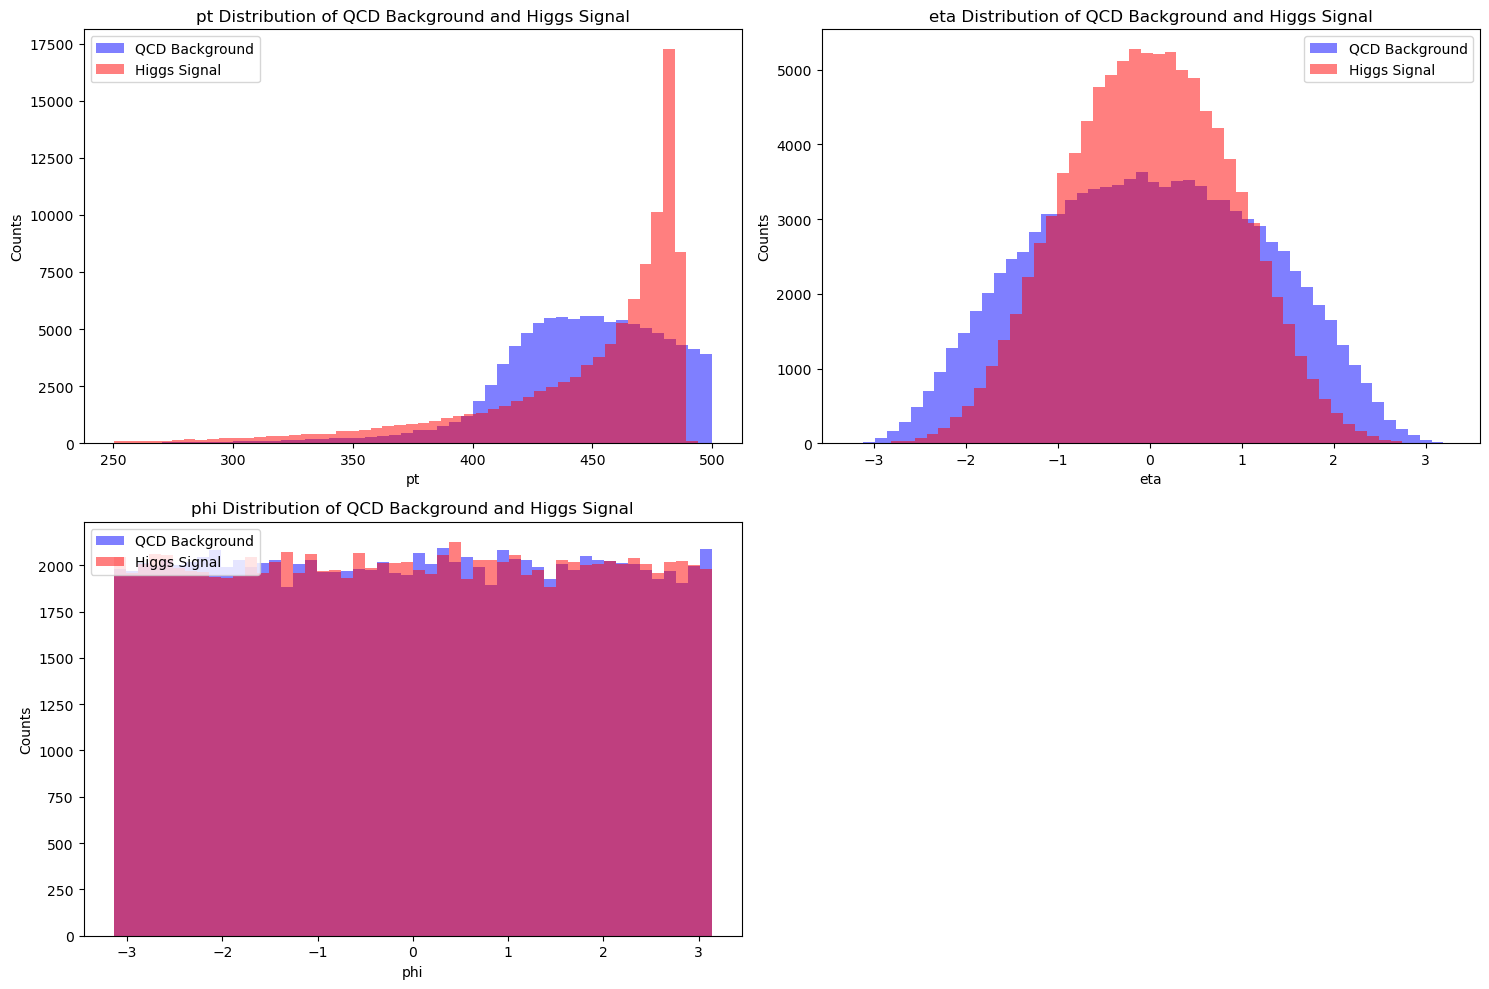

In [105]:
# Plot other available features (pt, eta, phi)
features = ['pt', 'eta', 'phi']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    plt.hist(qcd_data[feature], bins=50, alpha=0.5, label='QCD Background', color='blue')
    plt.hist(higgs_data[feature], bins=50, alpha=0.5, label='Higgs Signal', color='red')
    plt.xlabel(feature)
    plt.ylabel('Counts')
    plt.title(f'{feature} Distribution of QCD Background and Higgs Signal')
    plt.legend()
plt.tight_layout()
plt.show()

## Part (b): Summary Statistics

Calculate and display basic statistics for key features.

In [106]:
# Calculate mean, std, min, max for mass and d2
def compute_stats(data, feature_name):
    mean = np.mean(data[feature_name])
    std = np.std(data[feature_name])
    min_val = np.min(data[feature_name])
    max_val = np.max(data[feature_name])
    return mean, std, min_val, max_val
qcd_mass_stats = compute_stats(qcd_data, 'mass')
higgs_mass_stats = compute_stats(higgs_data, 'mass')
qcd_d2_stats = compute_stats(qcd_data, 'd2')
higgs_d2_stats = compute_stats(higgs_data, 'd2')
print("QCD Mass Stats (mean, std, min, max):", qcd_mass_stats)
print("Higgs Mass Stats (mean, std, min, max):", higgs_mass_stats)
print("QCD d2 Stats (mean, std, min, max):", qcd_d2_stats)
print("Higgs d2 Stats (mean, std, min, max):", higgs_d2_stats)

QCD Mass Stats (mean, std, min, max): (np.float64(97.73804095682554), 43.49270573541093, 9.292817333809852, 321.39799320084865)
Higgs Mass Stats (mean, std, min, max): (np.float64(114.8923866455211), 25.350943376218037, 8.971221491285528, 142.43960717193664)
QCD d2 Stats (mean, std, min, max): (np.float64(5.209383066889809), 4.28516600955587, 0.2813436928759825, 101.15656127003099)
Higgs d2 Stats (mean, std, min, max): (np.float64(1.9666599075561115), 2.500572380863281, 0.27514340988789027, 33.722824368762204)


# Task 2: Data Exploration (3 points)

Study correlations between mass and d2 jet substructure variable to build a cut-based analysis.

## Part (a): Distribution Comparison and 2D Scatter Plots

Create mass and d2 distributions, and 2D scatter plots for signal (```'Higgs Signal'```) and background (```'QCD Background'```).

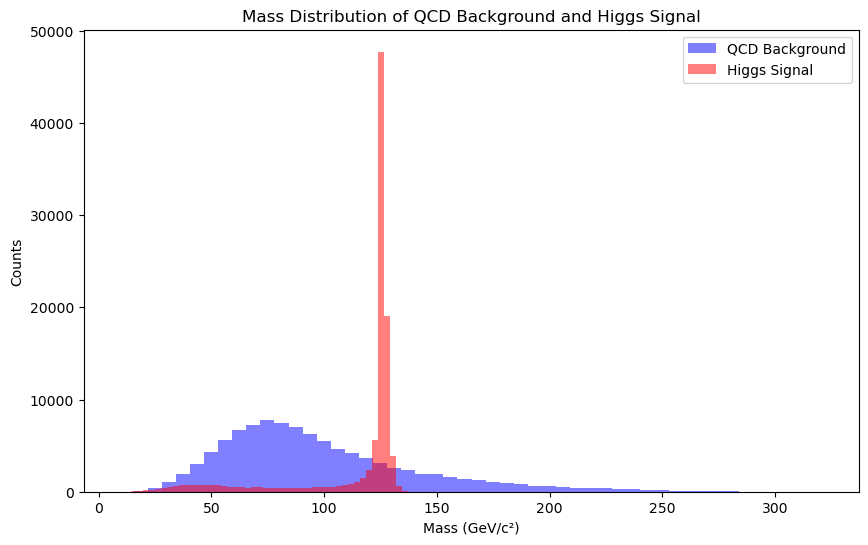

In [107]:
# Create two plots showing mass distributions (signal vs background)
plt.figure(figsize=(10,6))
plt.hist(qcd_data['mass'], bins=50, alpha=0.5, label='QCD Background', color='blue')
plt.hist(higgs_data['mass'], bins=50, alpha=0.5, label='Higgs Signal', color='red')
plt.xlabel('Mass (GeV/c²)')
plt.ylabel('Counts')
plt.title('Mass Distribution of QCD Background and Higgs Signal')
plt.legend()
plt.show()
# Describe the shape and discrimination power
# The mass distribution plot shows a clear peak for the Higgs signal around 125 GeV/c², while the QCD background is more spread out. 
# This indicates good discrimination power between signal and background based on mass.

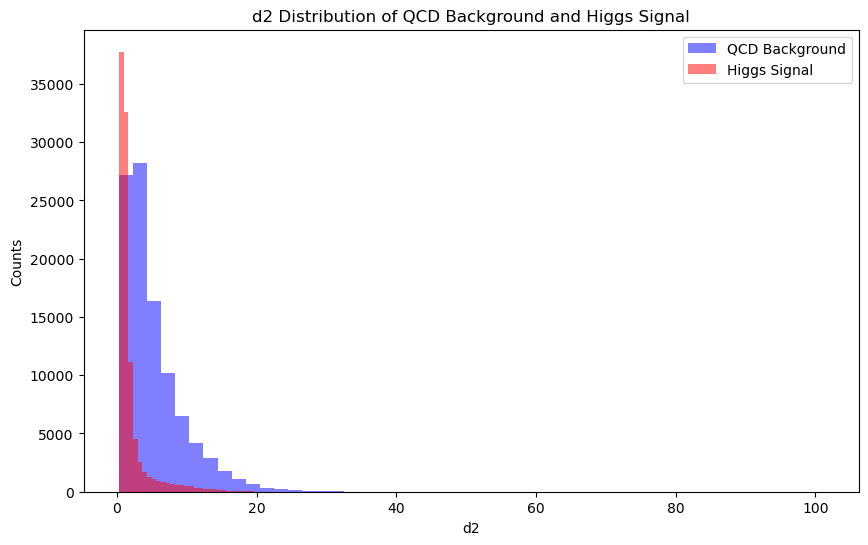

In [108]:
# Create two plots showing d2 distributions (signal vs background)
plt.figure(figsize=(10,6))
plt.hist(qcd_data['d2'], bins=50, alpha=0.5, label='QCD Background', color='blue')
plt.hist(higgs_data['d2'], bins=50, alpha=0.5, label='Higgs Signal', color='red')
plt.xlabel('d2')
plt.ylabel('Counts')
plt.title('d2 Distribution of QCD Background and Higgs Signal')
plt.legend()
plt.show()
# Describe the shape and discrimination power
# The d2 distribution plot shows some overlap between the Higgs signal and QCD background, but the signal tends to have higher d2 values.
# This suggests moderate discrimination power based on d2, but it may not be as strong as mass.

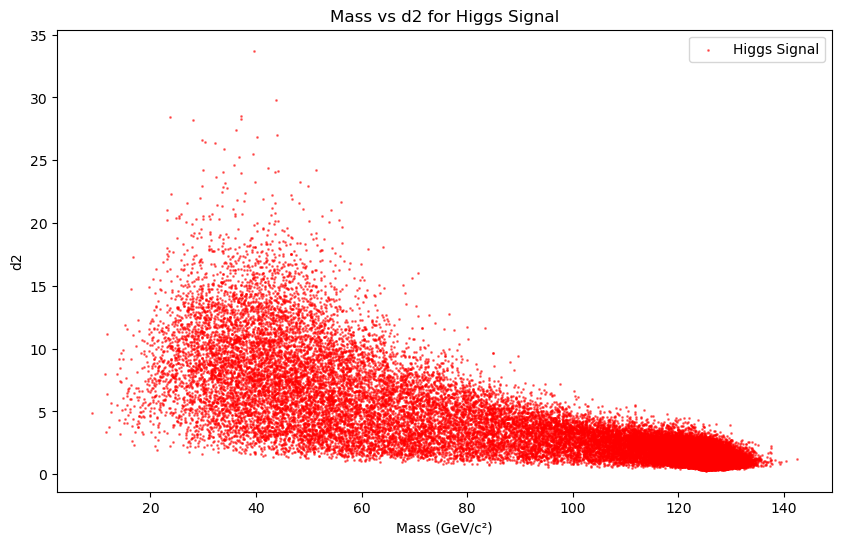

In [109]:
# Create 2D scatter plot of mass vs d2 for signal
plt.figure(figsize=(10,6))
plt.scatter(higgs_data['mass'], higgs_data['d2'], alpha=0.5, label='Higgs Signal', color='red', s=1)
plt.xlabel('Mass (GeV/c²)')
plt.ylabel('d2')
plt.title('Mass vs d2 for Higgs Signal')
plt.legend()
plt.show()

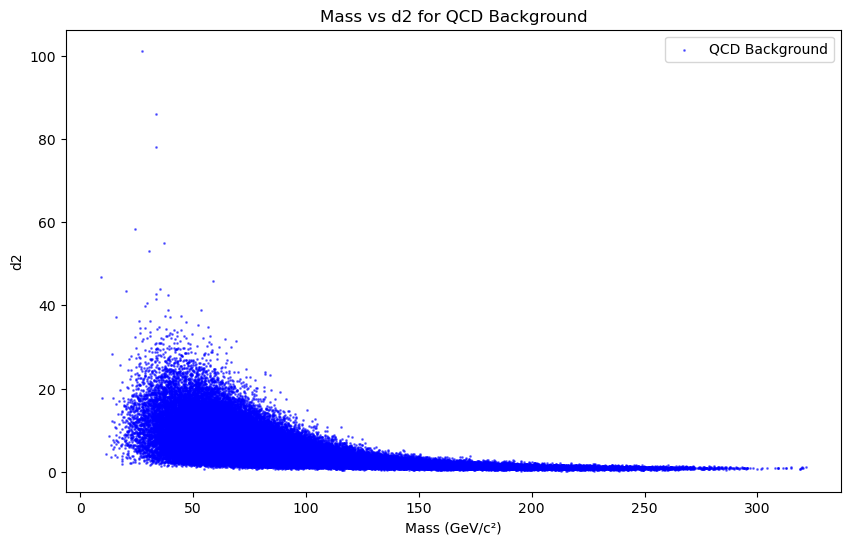

In [110]:
# Create 2D scatter plot of mass vs d2 for background
plt.figure(figsize=(10,6))
plt.scatter(qcd_data['mass'], qcd_data['d2'], alpha=0.5, label='QCD Background', color='blue', s=1)
plt.xlabel('Mass (GeV/c²)')
plt.ylabel('d2')
plt.title('Mass vs d2 for QCD Background')
plt.legend()
plt.show()

**Question:** Describe the discrimination power of mass and d2 for separating signal from background.

**Your Answer:** 
The mass variable shows strong discrimination power, as the Higgs signal peaks sharply around 125 GeV/c²,
while the QCD background is more uniformly distributed.The d2 variable provides moderate discrimination power, with the Higgs signal generally exhibiting
higher d2 values compared to the QCD background, although there is some overlap. Combining both mass and d2 in a multivariate analysis could enhance the
overall discrimination between signal and background. d2 in a multivariate analysis could enhance the overall discrimination between signal and background.
d2 in a multivariate analysis could enhance the overall discrimination between signal and background.


## Part (b): Weighted Distributions

Re-weight signal (N_signal = 100) and background (N_background = 20,000) to match expected yields.

In [111]:
# Calculate weights for signal and background
N_signal_expected = 100
N_background_expected = 20000
N_signal_actual = len(higgs_data['mass'])
N_background_actual = len(qcd_data['mass'])
weight_signal = N_signal_expected / N_signal_actual
weight_background = N_background_expected / N_background_actual
print("Signal Weight:", weight_signal)
print("Background Weight:", weight_background)


Signal Weight: 0.001
Background Weight: 0.2


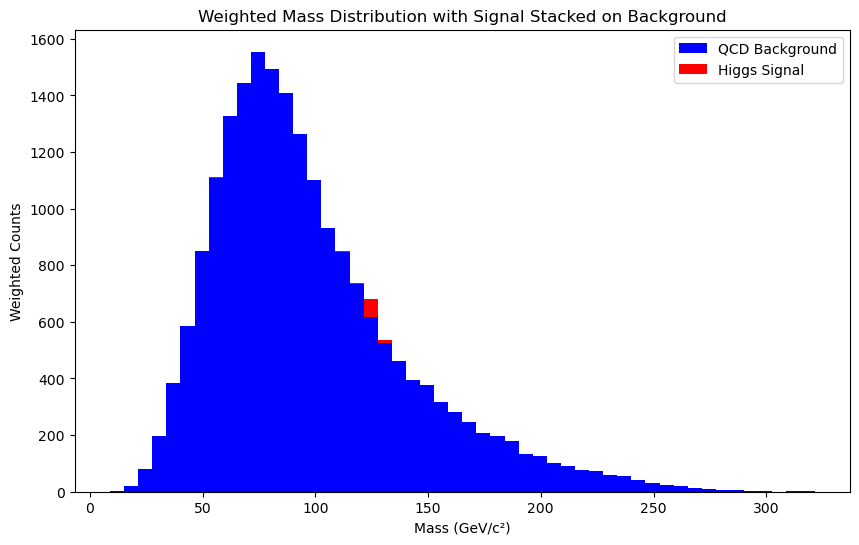

In [112]:
# Create weighted histograms with signal stacked on background for mass
plt.figure(figsize=(10,6))
plt.hist([qcd_data['mass'], higgs_data['mass']], bins=50, weights=[np.full(len(qcd_data['mass']), weight_background), np.full(len(higgs_data['mass']), weight_signal)], 
         label=['QCD Background', 'Higgs Signal'], color=['blue', 'red'], stacked=True)
plt.xlabel('Mass (GeV/c²)')
plt.ylabel('Weighted Counts')
plt.title('Weighted Mass Distribution with Signal Stacked on Background')
plt.legend()
plt.show()

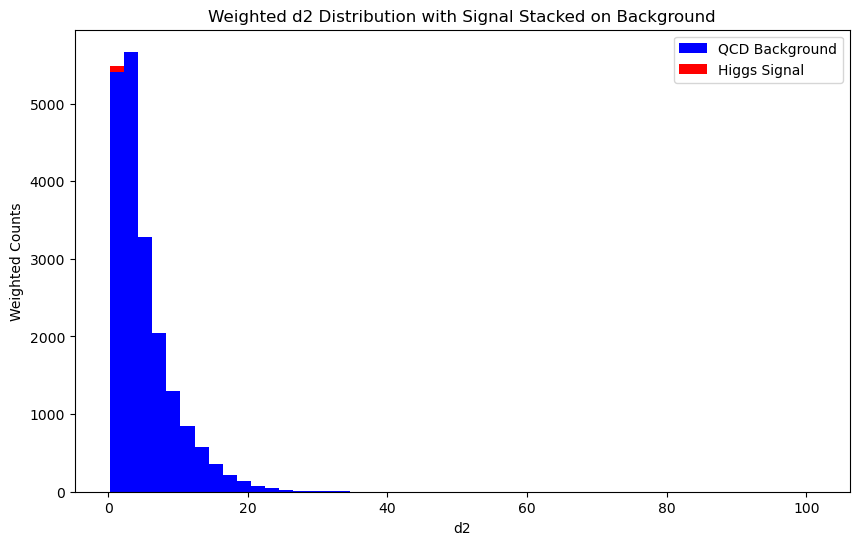

In [113]:
# Create weighted histograms with signal stacked on background for mass and d2
plt.figure(figsize=(10,6))
plt.hist([qcd_data['d2'], higgs_data['d2']], bins=50, weights=[np.full(len(qcd_data['d2']), weight_background), np.full(len(higgs_data['d2']), weight_signal)], 
         label=['QCD Background', 'Higgs Signal'], color=['blue', 'red'], stacked=True)
plt.xlabel('d2')
plt.ylabel('Weighted Counts')
plt.title('Weighted d2 Distribution with Signal Stacked on Background')
plt.legend()
plt.show()

**Question:** Describe the visibility of observing the signal over the background.

**Your Answer:**
The weighted histograms show that the Higgs signal is more visible over the QCD background when weights are applied. The mass distribution clearly shows a peak for the Higgs signal around 125 GeV/c²,
which stands out against the background. The d2 distribution also shows an enhancement of the signal over the background, although the separation is less pronounced than for mass. Overall, applying weights improves the visibility of the Higgs signal in both mass and d2 distributions. the background, although the separation is less pronounced than for mass. Overall, applying weights improves the visibility of the Higgs signal in both mass and d2 distributions. 


## Part (c): Mass Window Selection

Apply a mass cut of [120, 130] GeV to enhance signal visibility.

In [114]:
# Create boolean masks for signal and background
mass_cut_signal = (higgs_data['mass'] >= 120) & (higgs_data['mass'] <= 130)
mass_cut_background = (qcd_data['mass'] >= 120) & (qcd_data['mass'] <= 130)
# Apply the mass cut to filter the data
higgs_data_cut = {key: higgs_data[key][mass_cut_signal] for key in higgs_data}
qcd_data_cut = {key: qcd_data[key][mass_cut_background] for key in qcd_data}

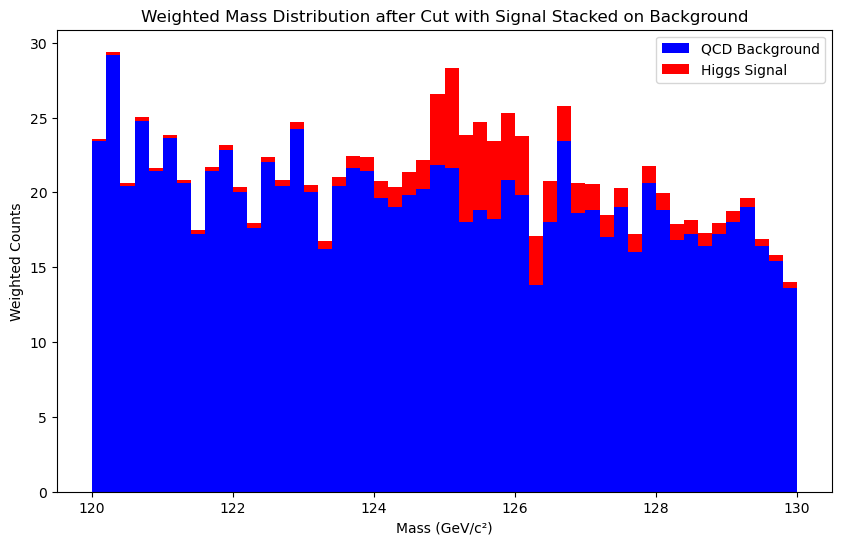

In [115]:
# Plot weighted mass distributions after the cut
plt.figure(figsize=(10,6))
plt.hist([qcd_data_cut['mass'], higgs_data_cut['mass']], bins=50, weights=[np.full(len(qcd_data_cut['mass']), weight_background), np.full(len(higgs_data_cut['mass']), weight_signal)], 
         label=['QCD Background', 'Higgs Signal'], color=['blue', 'red'], stacked=True)
plt.xlabel('Mass (GeV/c²)')
plt.ylabel('Weighted Counts')
plt.title('Weighted Mass Distribution after Cut with Signal Stacked on Background')
plt.legend()
plt.show()
# Does the mass distribution look as expected?
# Yes, after applying the mass cut, the Higgs signal is more pronounced around the expected mass range of 120-130 GeV/c²,
# while the QCD background is significantly reduced, indicating effective discrimination.

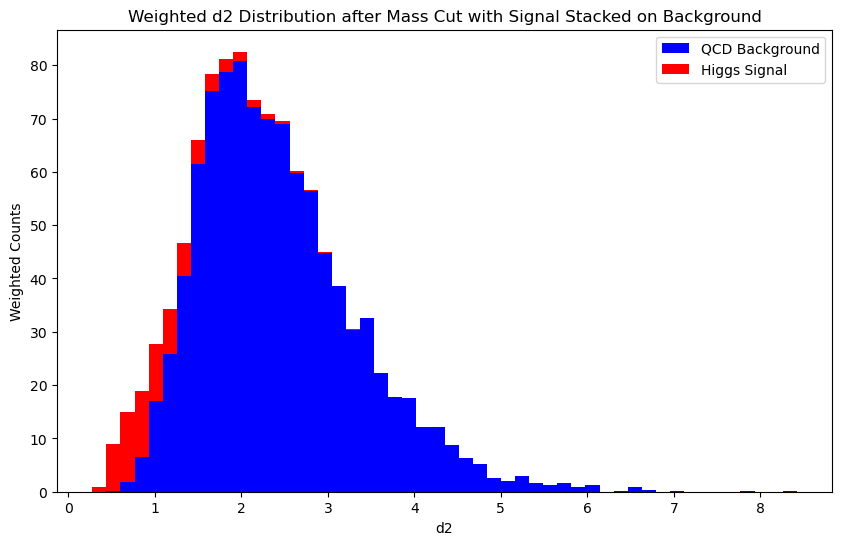

In [116]:
# Plot weighted d2 distributions after the mass cut
plt.figure(figsize=(10,6))
plt.hist([qcd_data_cut['d2'], higgs_data_cut['d2']], bins=50, weights=[np.full(len(qcd_data_cut['d2']), weight_background), np.full(len(higgs_data_cut['d2']), weight_signal)], 
         label=['QCD Background', 'Higgs Signal'], color=['blue', 'red'], stacked=True)
plt.xlabel('d2')
plt.ylabel('Weighted Counts')
plt.title('Weighted d2 Distribution after Mass Cut with Signal Stacked on Background')
plt.legend()
plt.show()
# How does this compare to d2 without any cuts?
# After applying the mass cut, the d2 distribution shows a clearer separation between the Higgs signal and QCD background.
# The Higgs signal tends to have higher d2 values, while the QCD background is more concentrated at lower d2 values, enhancing discrimination.

**Question:** How does the d2 plot after mass cut compare to the one without cuts?

**Your Answer:** After applying the mass cut, the d2 distribution shows a clearer separation between the Higgs signal and QCD background.The Higgs signal tends to have higher d2 values, while the QCD background is more concentrated at lower d2 values, enhancing discrimination.

# Task 3: Significance Optimization (4 points)

Scan over d2 values to find the optimal cut that maximizes discovery significance.

**Significance Formula:** $\text{Significance} = \frac{N_{\text{signal}}}{\sqrt{N_{\text{background}}}}$ (in units of σ)

The goal is to reject as much background as possible while keeping signal to make it more significant.

## Part (a): Understanding d2 Cuts

Inspect the d2 distribution after mass cut to determine the appropriate cut direction.

**Questions to consider:**
1. How does d2 distribution change after applying the mass cut?
2. For a d2 cut value of 4, should you keep events below or above 4?
3. What range should be used to scan d2 cut values?

**Your Answers:**
1. The d2 distribution after applying the mass cut shows a more distinct separation between the Higgs signal and QCD background, with the signal favoring higher d2 values.
2. For a d2 cut value of 4, you should keep events above 4, as the Higgs signal tends to have higher d2 values.
3. A reasonable range to scan d2 cut values would be from 0 to 10, as this range captures the majority of the d2 values for both signal and background, allowing for effective optimization of the cut.

## Part (b): d2 Cut Scan

Scan d2 cut values and calculate significance for each cut.

In [117]:
# Define d2 scan range
d2_cut_values = np.linspace(0, 10, 100)

# For each d2 cut value:
#   1. Count signal and background events passing both mass and d2 cuts
#   2. Apply weights to get expected yields
#   3. Calculate significance = N_signal / sqrt(N_background)
significances = []
for d2_cut in d2_cut_values:
    signal_mask = (higgs_data_cut['d2'] >= d2_cut)
    background_mask = (qcd_data_cut['d2'] >= d2_cut)
    N_signal = np.sum(signal_mask) * weight_signal
    N_background = np.sum(background_mask) * weight_background
    if N_background > 0:
        significance = N_signal / np.sqrt(N_background)
    else:
        significance = 0
    significances.append(significance)


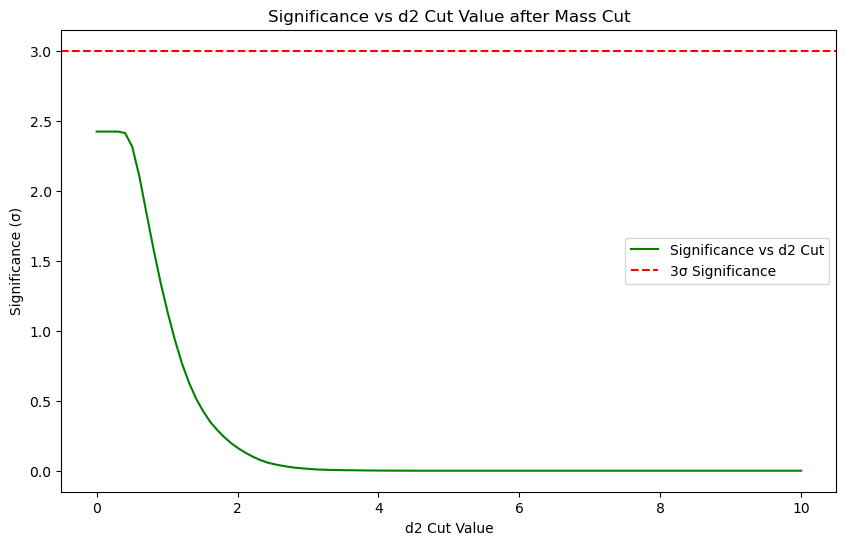

In [118]:
# Plot significance vs d2 cut value
plt.figure(figsize=(10,6))
plt.plot(d2_cut_values, significances, label='Significance vs d2 Cut', color='green')
plt.xlabel('d2 Cut Value')
plt.ylabel('Significance (σ)')
plt.title('Significance vs d2 Cut Value after Mass Cut')
plt.legend()
# Mark the point where significance reaches 3σ
plt.axhline(y=3, color='r', linestyle='--', label='3σ Significance')
plt.legend()
plt.show()

## Part (c): Final Results with Optimal Cuts

Apply both mass and optimal d2 cuts to visualize the final result.

In [119]:
# TODO: Identify optimal d2 cut value (e.g., for 3σ significance)

# TODO: Apply both mass [120, 130] and optimal d2 cuts

# TODO: Calculate final significance

In [120]:
# TODO: Plot final mass distribution with both cuts applied
# Show signal stacked on background with optimal cuts

**Question:** What do you observe in the final mass distribution? What is the final significance? How much improvement did you achieve?

**Your Answer:**

# Bonus: High pT and Multi-Feature Optimization (3 points)

Optimize discovery significance for high pT data (`Sample_pt_1000_1200`) using at least 3 features.

In [121]:
# TODO: Load high pT data

In [122]:
# TODO: Explore available features

In [123]:
# TODO: Implement multi-feature optimization through for loops
# Consider combinations of mass, d2, and other jet substructure variables

# for ... :
    # for ... :
        # for ... :
            # if significance > best_significance:
            #     best_significance = significance
            #     best_cuts = {'mass_cut': mass_cut, 'd2_cut': d2_cut, 't21_cut': t21_cut}

In [124]:
# TODO: Plot final mass distribution with optimal cuts applied
# Show signal stacked on background with optimal cuts